# ACF and PACF

**Autocorrelation Function / Partial Autocorrelation Function**

Before we can investigate <em>autoregression</em> as a modeling tool, we need to look at <em>covariance</em> and <em>correlation</em> as they relate to lagged (shifted) samples of a time series.

ACF and PACF are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps. The difference between autocorrelation and partial autocorrelation can be difficult and confusing for beginners to time series forecasting.


### Goals
 * Be able to create ACF and PACF charts
 * Create these charts for multiple times series, one with seasonality and another without
 * Be able to calculate Orders PQD terms for ARIMA off these charts (highlight where they cross the x axis)
 
<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acovf.html'>stattools.acovf</a></strong><font color=black>(x[, unbiased, demean, fft, …])</font>&nbsp;Autocovariance for 1D<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acf.html'>stattools.acf</a></strong><font color=black>(x[, unbiased, nlags, qstat, …])</font>&nbsp;&nbsp;Autocorrelation function for 1d arrays<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf.html'>stattools.pacf</a></strong><font color=black>(x[, nlags, method, alpha])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Partial autocorrelation estimated<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf_yw.html'>stattools.pacf_yw</a></strong><font color=black>(x[, nlags, method])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Partial autocorrelation estimated with non-recursive yule_walker<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf_ols.html'>stattools.pacf_ols</a></strong><font color=black>(x[, nlags])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Calculate partial autocorrelations</tt>
   
<h3>Related Plot Methods:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html'>tsaplots.plot_acf</a></strong><font color=black>(x)</font>&nbsp;&nbsp;&nbsp;Plot the autocorrelation function<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html'>tsaplots.plot_pacf</a></strong><font color=black>(x)</font>&nbsp;&nbsp;Plot the partial autocorrelation function</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://en.wikipedia.org/wiki/Autocovariance'>Wikipedia:</a></strong>&nbsp;&nbsp;<font color=black>Autocovariance</font><br>
<strong>
<a href='https://otexts.com/fpp2/autocorrelation.html'>Forecasting: Principles and Practice</a></strong>&nbsp;&nbsp;<font color=black>Autocorrelation</font><br>
<strong>
<a href='https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4463.htm'>NIST Statistics Handbook</a></strong>&nbsp;&nbsp;<font color=black>Partial Autocorrelation Plot</font></div>


## Perform standard imports and load datasets

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import statsmodels.api as sm

import pathlib
path = pathlib.Path(r"C:\Users\saurabhkumar9\15. TimeSeries\Data")

# Load a non-stationary dataset
df1 = pd.read_csv(path/'airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

# Load a stationary dataset
df2 = pd.read_csv(path/'DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

In [2]:
# Import the models we'll be using in this section
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols

### Ignore harmless warnings
A quick note before we get started. Many of the models used in this and upcoming sections are likely to raise harmless warnings.<br>For instance, the unbiased partial autocorrelation <tt>pacf_yw()</tt> performed below may raise a <tt>RuntimeWarning: invalid value encountered in sqrt</tt>.<br>
We don't really need to be concerned with this, and we can avoid it with the following code:

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Autocovariance for 1D
In a <em>deterministic</em> process, like $y=sin(x)$, we always know the value of $y$ for a given value of $x$. However, in a <em>stochastic</em> process there is always some randomness that prevents us from knowing the value of $y$. Instead, we analyze the past (or <em>lagged</em>) behavior of the system to derive a probabilistic estimate for $\hat{y}$.

One useful descriptor is <em>covariance</em>. When talking about dependent and independent $x$ and $y$ variables, covariance describes how the variance in $x$ relates to the variance in $y$. Here the size of the covariance isn't really important, as $x$ and $y$ may have very different scales. However, if the covariance is positive it means that $x$ and $y$ are changing in the same direction, and may be related.

With a time series, $x$ is a fixed interval. Here we want to look at the variance of $y_t$ against lagged or shifted values of $y_{t+k}$

For a stationary time series, the autocovariance function for $\gamma$ (gamma) is given as:

${\displaystyle {\gamma}_{XX}(t_{1},t_{2})=\operatorname {Cov} \left[X_{t_{1}},X_{t_{2}}\right]=\operatorname {E} [(X_{t_{1}}-\mu _{t_{1}})(X_{t_{2}}-\mu _{t_{2}})]}$

We can calculate a specific $\gamma_k$ with:

${\displaystyle \gamma_k = \frac 1 n \sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})}$


<div class="alert alert-info"><strong>A NOTE ON FORMULA CONVENTIONS:</strong> Different texts employ different symbol conventions. For example, in the above autocovariance formula we use $k$ to represent the amount of lag or shift. Some texts use $h$ instead.</div>


### Autocovariance Example:
Say we have a time series with five observations: {13, 5, 11, 12, 9}.<br>
We can quickly see that $n = 5$, the mean $\bar{y} = 10$, and we'll see that the variance $\sigma^2 = 8$.<br>
The following calculations give us our covariance values:
<br><br>
$\gamma_0 = \frac {(13-10)(13-10)+(5-10)(5-10)+(11-10)(11-10)+(12-10)(12-10)+(9-10)(9-10)} 5 = \frac {40} 5 = 8.0 \\
\gamma_1 = \frac {(13-10)(5-10)+(5-10)(11-10)+(11-10)(12-10)+(12-10)(9-10)} 5 = \frac {-20} 5 = -4.0 \\
\gamma_2 = \frac {(13-10)(11-10)+(5-10)(12-10)+(11-10)(9-10)} 5 = \frac {-8} 5 = -1.6 \\
\gamma_3 = \frac {(13-10)(12-10)+(5-10)(9-10)} 5 = \frac {11} 5 = 2.2 \\
\gamma_4 = \frac {(13-10)(9-10)} 5 = \frac {-3} 5 = -0.6$
<br><br>
Note that $\gamma_0$ is just the population variance $\sigma^2$

Let's see if statsmodels gives us the same results! For this we'll create a <strong>fake</strong> dataset:

In [5]:
df = pd.DataFrame({'a':[13, 5, 11, 12, 9]})
arr = acovf(df['a'])
arr

array([ 8. , -4. , -1.6,  2.2, -0.6])

### Unbiased Autocovariance
Note that the number of terms in the calculations above are decreasing.<br>Statsmodels can return an "unbiased" autocovariance where instead of dividing by $n$ we divide by $n-k$.

$\gamma_0 = \frac {(13-10)(13-10)+(5-10)(5-10)+(11-10)(11-10)+(12-10)(12-10)+(9-10)(9-10)} {5-0} = \frac {40} 5 = 8.0 \\
\gamma_1 = \frac {(13-10)(5-10)+(5-10)(11-10)+(11-10)(12-10)+(12-10)(9-10)} {5-1} = \frac {-20} 4 = -5.0 \\
\gamma_2 = \frac {(13-10)(11-10)+(5-10)(12-10)+(11-10)(9-10)} {5-2} = \frac {-8} 3 = -2.67 \\
\gamma_3 = \frac {(13-10)(12-10)+(5-10)(9-10)} {5-3} = \frac {11} 2 = 5.5 \\
\gamma_4 = \frac {(13-10)(9-10)} {5-4} = \frac {-3} 1 = -3.0$

In [6]:
arr2 = acovf(df['a'],unbiased=True)
arr2

array([ 8.        , -5.        , -2.66666667,  5.5       , -3.        ])

## Autocorrelation for 1D
The correlation $\rho$ (rho) between two variables $y_1,y_2$ is given as:

### $\rho = \frac {\operatorname E[(y_1−\mu_1)(y_2−\mu_2)]} {\sigma_{1}\sigma_{2}} = \frac {\operatorname {Cov} (y_1,y_2)} {\sigma_{1}\sigma_{2}}$,

where $E$ is the expectation operator, $\mu_{1},\sigma_{1}$ and $\mu_{2},\sigma_{2}$ are the means and standard deviations of $y_1$ and $y_2$.

When working with a single variable (i.e. <em>autocorrelation</em>) we would consider $y_1$ to be the original series and $y_2$ a lagged version of it. Note that with autocorrelation we work with $\bar y$, that is, the full population mean, and <em>not</em> the means of the reduced set of lagged factors (see note below).

Thus, the formula for $\rho_k$ for a time series at lag $k$ is:

${\displaystyle \rho_k = \frac {\sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})} {\sum\limits_{t=1}^{n} (y_t - \bar{y})^2}}$

This can be written in terms of the covariance constant $\gamma_k$ as:

${\displaystyle \rho_k = \frac {\gamma_k n} {\gamma_0 n} = \frac {\gamma_k} {\sigma^2}}$

For example,<br>
$\rho_4 = \frac {\gamma_4} {\sigma^2} = \frac{-0.6} {8} = -0.075$

Note that ACF values are bound by -1 and 1. That is, ${\displaystyle -1 \leq \rho_k \leq 1}$

In [7]:
arr3 = acf(df['a'])
arr3

array([ 1.   , -0.5  , -0.2  ,  0.275, -0.075])

## Partial Autocorrelation
Partial autocorrelations measure the linear dependence of one variable after removing the effect of other variable(s) that affect both variables. That is, the partial autocorrelation at lag $k$ is the autocorrelation between $y_t$ and $y_{t+k}$ that is not accounted for by lags $1$ through $k−1$.

A common method employs the non-recursive <a href='https://en.wikipedia.org/wiki/Autoregressive_model#Calculation_of_the_AR_parameters'>Yule-Walker Equations</a>:

$\phi_0 = 1\\
\phi_1 = \rho_1 = -0.50\\
\phi_2 = \frac {\rho_2 - {\rho_1}^2} {1-{\rho_1}^2} = \frac {(-0.20) - {(-0.50)}^2} {1-{(-0.50)}^2}= \frac {-0.45} {0.75} = -0.60$

As $k$ increases, we can solve for $\phi_k$ using matrix algebra and the <a href='https://en.wikipedia.org/wiki/Levinson_recursion'>Levinson–Durbin recursion</a> algorithm which maps the sample autocorrelations $\rho$ to a <a href='https://en.wikipedia.org/wiki/Toeplitz_matrix'>Toeplitz</a> diagonal-constant matrix. The full solution is beyond the scope of this course, but the setup is as follows:


$\displaystyle \begin{pmatrix}\rho_0&\rho_1&\cdots &\rho_{k-1}\\
\rho_1&\rho_0&\cdots &\rho_{k-2}\\
\vdots &\vdots &\ddots &\vdots \\
\rho_{k-1}&\rho_{k-2}&\cdots &\rho_0\\
\end{pmatrix}\quad \begin{pmatrix}\phi_{k1}\\\phi_{k2}\\\vdots\\\phi_{kk}\end{pmatrix}
\mathbf = \begin{pmatrix}\rho_1\\\rho_2\\\vdots\\\rho_k\end{pmatrix}$

In [8]:
arr4 = pacf_yw(df['a'],nlags=4,method='mle')
arr4

array([ 1.        , -0.5       , -0.6       , -0.38541667, -0.40563273])

<div class="alert alert-info"><strong>NOTE:</strong> We passed in <tt><font color=black>method='mle'</font></tt> above in order to use biased ACF coefficients. "mle" stands for "maximum likelihood estimation". Alternatively we can pass <tt>method='unbiased'</tt> (the statsmodels default):</div>

In [9]:
arr5 = pacf_yw(df['a'],nlags=4,method='unbiased')
arr5

array([ 1.        , -0.625     , -1.18803419,  2.03764205,  0.8949589 ])

### Partial Autocorrelation with OLS
This provides partial autocorrelations with <a href='https://en.wikipedia.org/wiki/Ordinary_least_squares'>ordinary least squares</a> (OLS) estimates for each lag instead of Yule-Walker.

In [10]:
arr6 = pacf_ols(df['a'],nlags=4)
arr6

array([ 1.        , -0.49677419, -0.43181818,  0.53082621,  0.25434783])

# Plotting

The arrays returned by <tt>.acf(df)</tt> and <tt>.pacf_yw(df)</tt> show the magnitude of the autocorrelation for a given $y$ at time $t$. Before we look at plotting arrays, let's look at the data itself for evidence of autocorrelation.

Pandas has a built-in plotting function that plots increasing $y_t$ values on the horizontal axis against lagged versions of the values $y_{t+1}$ on the vertical axis. If a dataset is non-stationary with an upward trend, then neighboring values should trend in the same way. Let's look at the <strong>Airline Passengers</strong> dataset first.

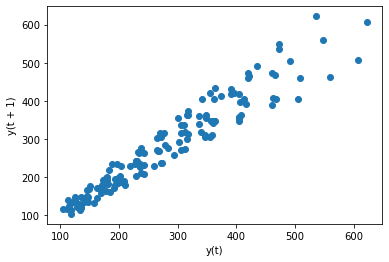

In [11]:
from pandas.plotting import lag_plot

lag_plot(df1['Thousands of Passengers']);

Visually this shows evidence of a very strong autocorrelation; as $y_t$ values increase, nearby (lagged) values also increase.

Now let's look at the stationary <strong>Daily Total Female Births</strong> dataset:

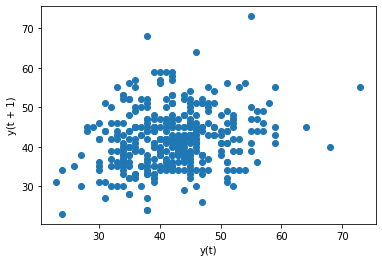

In [12]:
lag_plot(df2['Births']);

As expected, there is little evidence of autocorrelation here.

## ACF Plots
Plotting the magnitude of the autocorrelations over the first few (20-40) lags can say a lot about a time series.

For example, consider the stationary <strong>Daily Total Female Births</strong> dataset:

In [13]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [14]:
# Let's look first at the ACF array. By default acf() returns 40 lags
acf(df2['Births'])

array([ 1.        ,  0.21724118,  0.15287758,  0.10821254,  0.09066059,
        0.09595481,  0.09104012,  0.19508071,  0.14115295,  0.06117859,
        0.04781522,  0.04770662, -0.01964707,  0.02287422,  0.08112657,
        0.11185686,  0.07333732,  0.01501845,  0.07270333,  0.06859   ,
        0.09280107,  0.26386846,  0.14012147,  0.06070286,  0.08716232,
        0.05038825,  0.0650489 ,  0.11466565,  0.1552232 ,  0.12850638,
        0.10358981,  0.09734643,  0.04912286,  0.04022798,  0.05838555,
        0.05359812,  0.10151053,  0.08268663,  0.0912185 ,  0.11192192,
        0.05652846])

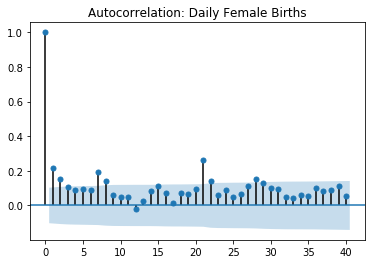

In [15]:
# Now let's plot the autocorrelation at different lags
title = 'Autocorrelation: Daily Female Births'
lags = 40
plot_acf(df2,title=title,lags=lags);

This is a typical ACF plot for stationary data, with lags on the horizontal axis and correlations on the vertical axis. The first value $y_0$ is always 1. A sharp dropoff indicates that there is no AR component in the ARIMA model.

Next we'll look at non-stationary data with the <strong>Airline Passengers</strong> dataset:

In [16]:
acf(df1['Thousands of Passengers'])

array([1.        , 0.94804734, 0.87557484, 0.80668116, 0.75262542,
       0.71376997, 0.6817336 , 0.66290439, 0.65561048, 0.67094833,
       0.70271992, 0.74324019, 0.76039504, 0.71266087, 0.64634228,
       0.58592342, 0.53795519, 0.49974753, 0.46873401, 0.44987066,
       0.4416288 , 0.45722376, 0.48248203, 0.51712699, 0.53218983,
       0.49397569, 0.43772134, 0.3876029 , 0.34802503, 0.31498388,
       0.28849682, 0.27080187, 0.26429011, 0.27679934, 0.2985215 ,
       0.32558712, 0.3370236 , 0.30333486, 0.25397708, 0.21065534,
       0.17217092])

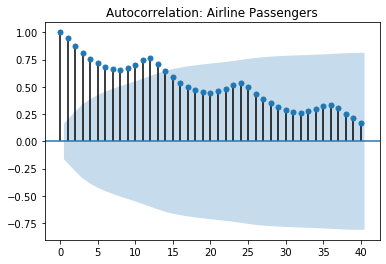

In [17]:
title = 'Autocorrelation: Airline Passengers'
lags = 40
plot_acf(df1,title=title,lags=lags);

This plot indicates non-stationary data, as there are a large number of lags before ACF values drop off.

## PACF Plots
Partial autocorrelations work best with stationary data. Let's look first at <strong>Daily Total Female Births</strong>:

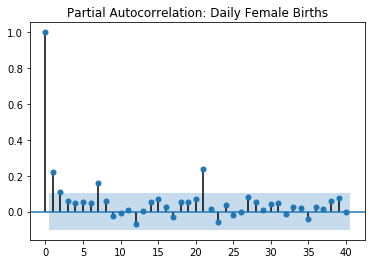

In [18]:
title='Partial Autocorrelation: Daily Female Births'
lags=40
plot_pacf(df2,title=title,lags=lags);

To make the <strong>Airline Passengers</strong> data stationary, we'll first apply <em>differencing</em>:

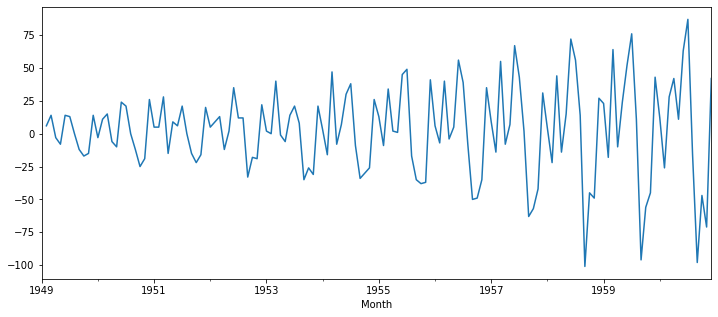

In [19]:
from statsmodels.tsa.statespace.tools import diff

df1['d1'] = diff(df1['Thousands of Passengers'],k_diff=1)
df1['d1'].plot(figsize=(12,5));

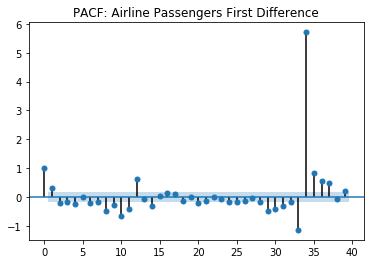

In [20]:
title='PACF: Airline Passengers First Difference'
lags=40
plot_pacf(df1['d1'].dropna(),title=title,lags=np.arange(lags));  # be sure to add .dropna() here!

### Plot Resizing
In case you want to display the full autocorrelation plot, it helps to increase the figure size using matplotlib:

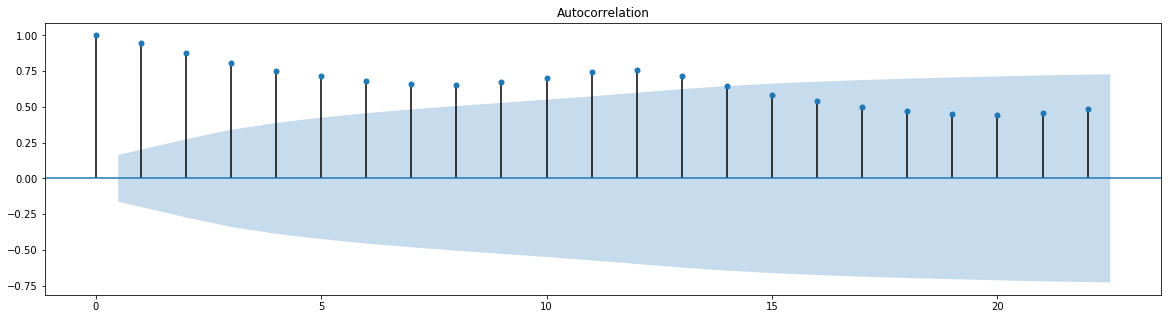

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,5))

plot_acf(df1['Thousands of Passengers'],ax=ax);

<div class="alert alert-success"><strong>A NOTE ABOUT AUTOCORRELATION:</strong> Some texts compute lagged correlations using the Pearson Correlation Coefficient given by:<br><br>
${\displaystyle r_{xy}={\frac {\sum _{i=1}^{n}(x_{i}-{\bar {x}})(y_{i}-{\bar {y}})}{{\sqrt {\sum _{i=1}^{n}(x_{i}-{\bar {x}})^{2}}}{\sqrt {\sum _{i=1}^{n}(y_{i}-{\bar {y}})^{2}}}}}}$

These are easily calculated in numpy with <tt>numpy.corrcoef(x,y)</tt> and in Excel with <tt>=CORREL(x,y)</tt>.<br><br>
Using our example, $r_0$ is still $1$, but to solve for $r_1$:

${\displaystyle x_1 = [13, 5, 11, 12], \bar{x_1} = 10.25}$<br><br>
$y_1 = [5, 11, 12, 9],\  \bar{y_1} = 9.25$<br><br>
$r_{{x_1}{y_1}}=\frac {(13-10.25)(5-9.25)+(5-10.25)(11-9.25)+(11-10.25)(12-9.25)+(12-10.25)(9-9.25)}
{\sqrt{((13-10.25)^2+(5-10.25)^2+(11-10.25)^2+(12-10.25)^2)}\sqrt{((5-9.25)^2+(11-9.25)^2+(12-9.25)^2+(9-9.25)^2)}} = \frac {-19.25} {33.38} = -0.577$
<br><br>
However, there are some shortcomings. Using the Pearson method, the second-to-last term $r_{k-1}$ will always be $1$ and the last term $r_k$ will always be undefined.
</div>

# ACF/PACF use for AR/MA

Autocorrelation and partial autocorrelation plots are heavily used in time series analysis and forecasting.

These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps. The difference between autocorrelation and partial autocorrelation can be difficult and confusing for beginners to time series forecasting.

**ACF:** In simple terms, it describes how well the present value of the series is related with its past values. A time series can have components like trend, seasonality, cyclic and residual. ACF considers all these components while finding correlations hence it’s a ‘complete auto-correlation plot’.

**PACF**: PACF is a partial auto-correlation function. Basically instead of finding correlations of present with lags like ACF, it finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value hence ‘partial’ and not ‘complete’ as we remove already found variations before we find the next correlation. So if there is any hidden information in the residual which can be modeled by the next lag, we might get a good correlation and we will keep that next lag as a feature while modeling. Remember while modeling we don’t want to keep too many features which are correlated as that can create multicollinearity issues. Hence we need to retain only the relevant features.

## Data

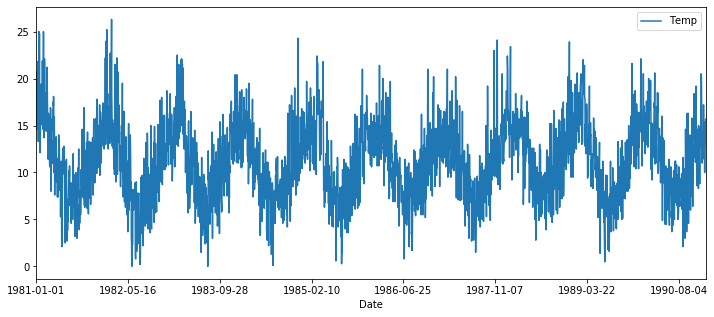

In [28]:
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv', 
                  header=0, index_col=0)
series.plot(figsize=(12,5))
pyplot.show()

## Correlation and Autocorrelation

Statistical correlation summarizes the strength of the relationship between two variables.

We can assume the distribution of each variable fits a Gaussian (bell curve) distribution. If this is the case, we can use the Pearson’s correlation coefficient to summarize the correlation between the variables.

The Pearson’s correlation coefficient is a number between -1 and 1 that describes a negative or positive correlation respectively. A value of zero indicates no correlation.

We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

A plot of the autocorrelation of a time series by lag is called the **A**uto**C**orrelation **F**unction, or the acronym ACF. This plot is sometimes called a correlogram or an autocorrelation plot.

Below is an example of calculating and plotting the autocorrelation plot for the Minimum Daily Temperatures using the plot_acf() function from the statsmodels library.

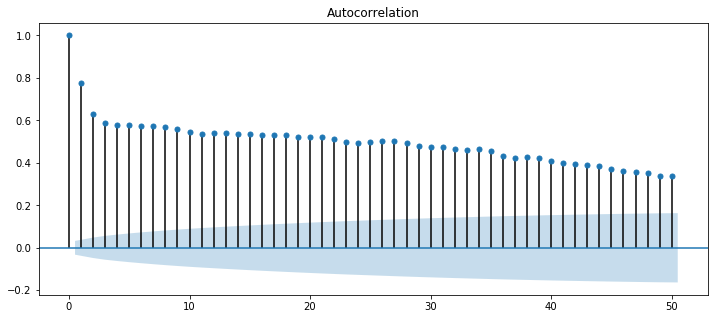

In [36]:
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(series, ax=ax, lags = 50)
pyplot.show()

Running the example creates a 2D plot showing the lag value along the x-axis and the correlation on the y-axis between -1 and 1.

Confidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.

## Partial Autocorrelation Function

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

*The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.*

The autocorrelation for an observation and an observation at a prior time step is comprised of both the direct correlation and indirect correlations. These indirect correlations are a linear function of the correlation of the observation, with observations at intervening time steps.

It is these indirect correlations that the partial autocorrelation function seeks to remove. Without going into the math, this is the intuition for the partial autocorrelation.

The example below calculates and plots a partial autocorrelation function for the first 50 lags in the Minimum Daily Temperatures dataset using the plot_pacf() from the statsmodels library.

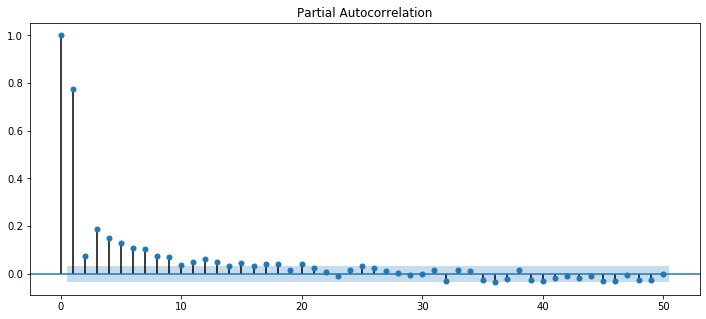

In [39]:
fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(series, lags=50, ax=ax)
pyplot.show()

## Intuition for ACF and PACF Plots

Plots of the autocorrelation function and the partial autocorrelation function for a time series tell a very different story.

We can use the intuition for ACF and PACF above to explore some thought experiments.

##### Autoregression Intuition

Consider a time series that was generated by an autoregression (AR) process with a lag of k.

We know that the ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information.

This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.

We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.

This is exactly the expectation of the ACF and PACF plots for an AR(k) process. 

**OR**

Auto regressive (AR) process , a time series is said to be AR when present value of the time series can be obtained using previous values of the same time series i.e the present value is weighted average of its past values. Stock prices and global temperature rise can be thought of as an AR processes.

The AR process of an order p can be written as,
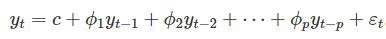
Where ϵt is a white noise and y’t-₁ and y’t-₂ are the lags. Order p is the lag value after which PACF plot crosses the upper confidence interval for the first time. These p lags will act as our features while forecasting the AR time series. We cannot use the ACF plot here because it will show good correlations even for the lags which are far in the past. If we consider those many features, we will have multicollinearity issues.This is not a problem with PACF plot as it removes components already explained by earlier lags, so we only get the lags which have the correlation with the residual i.e the component not explained by earlier lags.

AR process and found its order using the PACF plot. We should expect our AR process to show gradual decrease in the ACF plot since being an AR process its present has good correlation with the past lags. We expect PACF to have sharp fall after near lags as these lags near to present can capture the variation so well that we don’t need past lags to predict present.

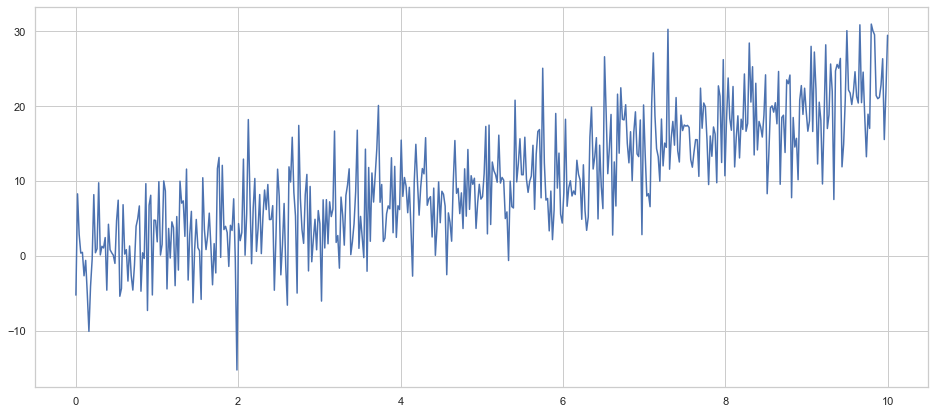

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 

import matplotlib
matplotlib.rc('xtick', labelsize=40) 
matplotlib.rc('ytick', labelsize=40) 

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
from statsmodels.tsa.stattools import acf, pacf


t = np.linspace(0, 10, 500)
#normal distributed values
ys = np.random.normal(0,5,500)

#exponential series to get the trend
ye = np.exp(t**0.5)
#adding normally distributed series in exponential series
y = ys+ye
#plot
plt.figure(figsize=(16,7))
plt.plot(t,y)

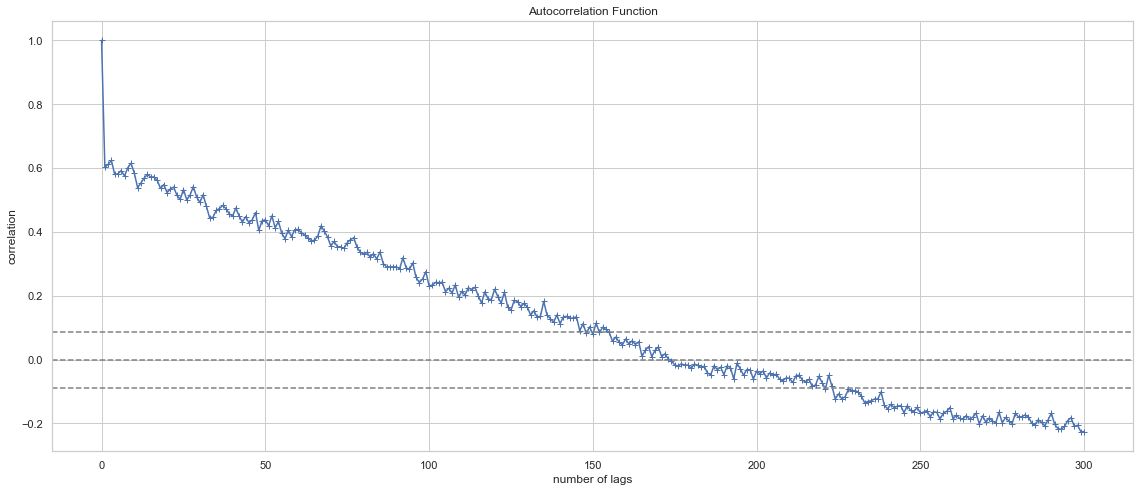

In [43]:
#calling auto correlation function
lag_acf = acf(y, nlags=300)
#Plot PACF:
plt.figure(figsize=(16, 7))
plt.plot(lag_acf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.tight_layout()

In the above correlation plot dotted lines represent the confidence band, with center dotted line represents mean and upper and lower dotted line represent boundries based on 95% confidence interval.

Notice that we have good positive correlation with the lags upto 150, this is the point where ACF plot cuts the upper confidence threshold. Although we have good correlation upto 150th lag we cannot use all of them as it will create multi-collinearity problem, thats why we turn to PACF plot to get only the most relevant lags!

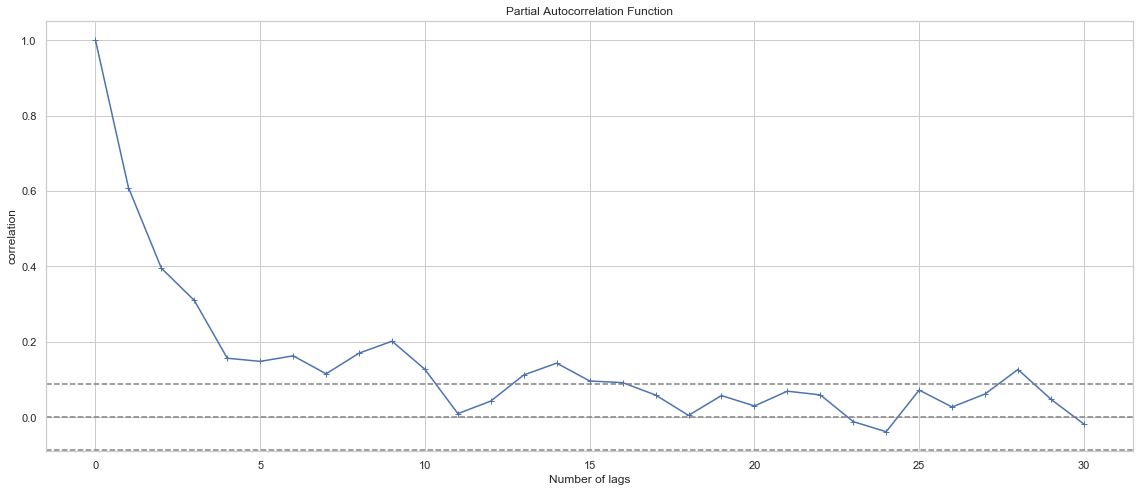

In [44]:
#calling partial correlation function
lag_pacf = pacf(y, nlags=30, method='ols')
#Plot PACF:
plt.figure(figsize=(16, 7))
plt.plot(lag_pacf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('correlation')
plt.tight_layout()

In the above plot we can see that lags upto 7 have good correlation before the plot first cuts the upper confidence interval. This is our p value i.e the order of our AR process. We can model given AR process using linear combination of first 7 lags.

##### Moving Average Intuition

Consider a time series that was generated by a moving average (MA) process with a lag of k.

Remember that the moving average process is an autoregression model of the time series of residual errors from prior predictions. Another way to think about the moving average model is that it corrects future forecasts based on errors made on recent forecasts.

We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. By definition, this is how the process was generated.

For the PACF, we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards.

Again, this is exactly the expectation of the ACF and PACF plots for an MA(k) process.

**OR**

**Moving average (MA)** process, a process where the present value of series is defined as a linear combination of past errors. We assume the errors to be independently distributed with the normal distribution. The MA process of order q is defined as ,
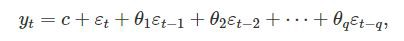
Here ϵt is a white noise. To get intuition of MA process lets consider order 1 MA process which will look like,
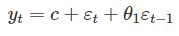
let’s consider y’t as the crude oil price and ϵt is the change in the oil price due to hurricane. Assume that c=10 (mean value of crude oil price when there is no hurricane) and θ₁=0.5. Suppose, there is a hurricane today and it was not present yesterday, so y’t will be 15 assuming the change in the oil price due to hurricane as ϵt=5. Tomorrow there is no hurricane so y’t will be 12.5 as ϵt=0 and ϵt-₁=5 . Suppose there is no hurricane day after tomorrow. In that case the oil price would be 10 which means it got stabilized back to mean after getting varied by hurricane. So the effect of hurricane only stays for one lagged value in our case. Hurricane in this case is an independent phenomenon.

Order q of the MA process is obtained from the ACF plot, this is the lag after which ACF crosses the upper confidence interval for the first time. As we know PACF captures correlations of residuals and the time series lags, we might get good correlations for nearest lags as well as for past lags. Why would that be? Since our series is linear combination of the residuals and none of time series own lag can directly explain its present (since its not an AR), which is the essence of PACF plot as it subtracts variations already explained by earlier lags, its kind of PACF losing its power here! On the other hand being a MA process, it doesn’t have the seasonal or trend components so the ACF plot will capture the correlations due residual components only. You can also think of it as ACF which is a complete plot (capturing trend, seasonality, cyclic and residual correlations) acting as a partial plot since we don’t have trends, seasons, etc.

In the below code, I have defined a simple MA process and found its order using the ACF plot. We can expect the ACF plot to show good correlation with nearest lags and then sharp fall as its not an AR process to have good correlation with past lags. Also we would expect the PACF plot to have gradual decrease as being an MA process, nearest lag values of time series cannot really predict its present value unlike AR process.So, we will get good correlations of residuals with further lags as well, hence the gradual decrease.

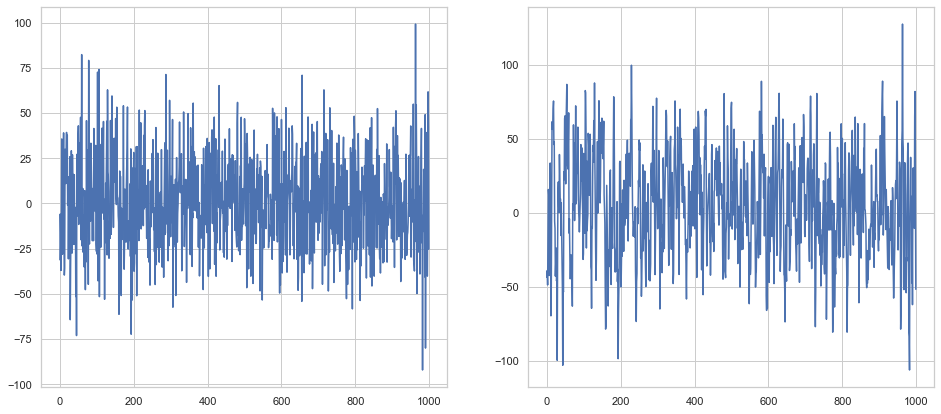

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 

import matplotlib
matplotlib.rc('xtick', labelsize=40) 
matplotlib.rc('ytick', labelsize=40) 

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

#xma = np.random.randint(1,50000,100)
xma = np.random.normal(0,25,1000)

#lets create a MA series having mean 2 and of order 2
y5 = 2 + xma + 0.8*np.roll(xma,-1) + 0.6*np.roll(xma,-2) #+ 0.6 *np.roll(xma,-3)

plt.figure(figsize=(16, 7))
#Plot ACF: 
plt.subplot(121) 
plt.plot(xma)
plt.subplot(122)
plt.plot(y5)

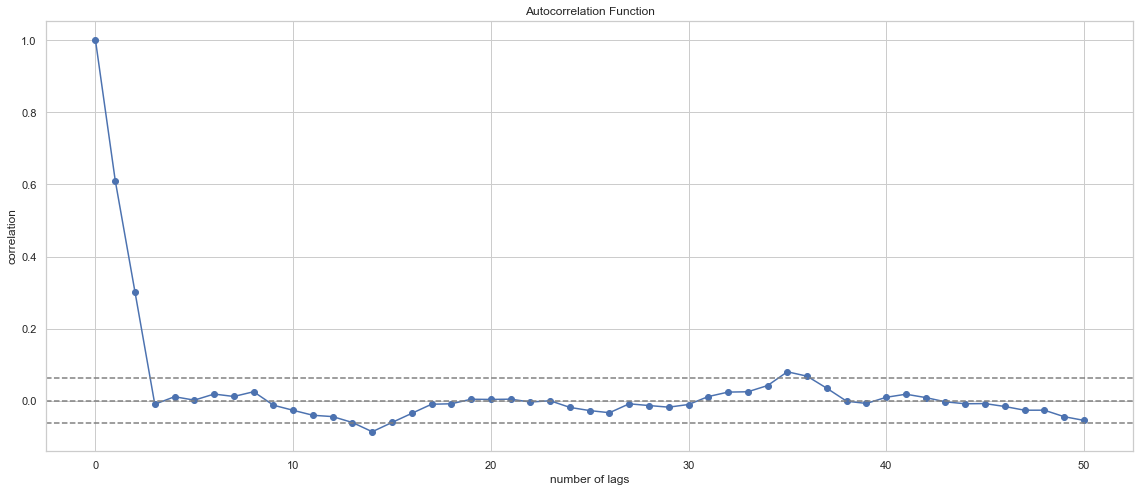

In [46]:
#calling acf function from stattools
lag_acf = acf(y5, nlags=50)
plt.figure(figsize=(16, 7))
#Plot ACF: 
plt.plot(lag_acf, marker="o")
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y5)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y5)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.tight_layout()

As per above plot we have good correlation upto 2nd lag, this is the lag after which plot cuts the upper confidence interval. Order q of series obtained by the plot is 2, which is correct as we had defined our series with linear combination of residuals upto lag 2.
Thus this proves that ACF correctly predicted order of our MA series.

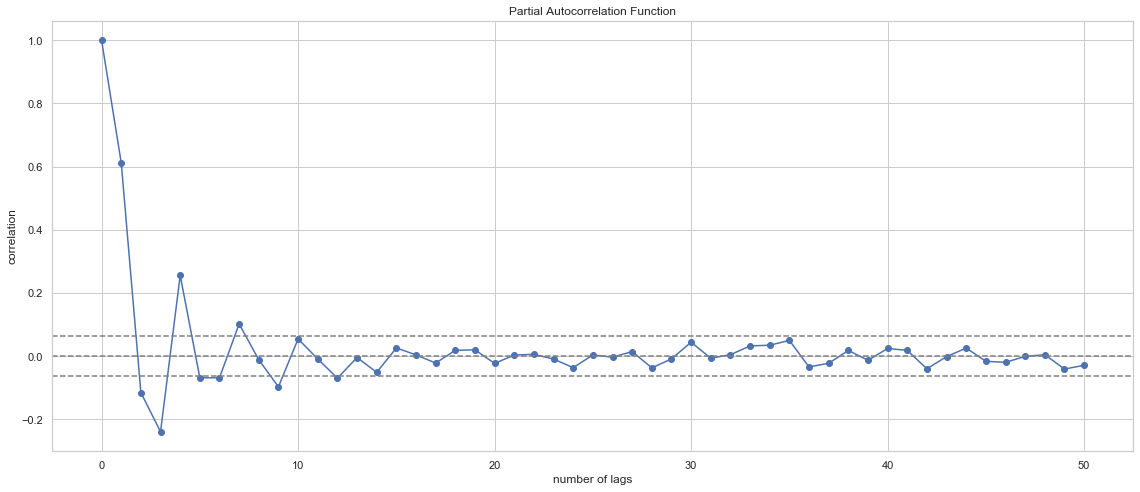

In [47]:
#calling pacf function from stattool
lag_pacf = pacf(y5, nlags=50, method='ols')

#PLOT PACF
plt.figure(figsize=(16, 7))
plt.plot(lag_pacf, marker="o")
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y5)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y5)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.tight_layout()

If we see PACF plot there are many instances where correlation is above upper confidence band as PACF calculates correlations of lags of time series with residuals and our series itself is linear combination of residual and its lagged values.Hence we can get good correlation for near as well as past lags.

##### **Conclusion**:
    
While building a machine learning model we should avoid multicollinear features. The same applies to time series models as well.

We find optimum features or order of the AR process using the PACF plot, as it removes variations explained by earlier lags so we get only the relevant features.

We find optimum features or order of the MA process using the ACF plot, as being an MA process it doesn’t have seasonal and trend components so we get only the residual relationship with the lags of time series in the ACF plot. ACF acting as a partial plot.